In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import os
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as keras
from scipy import stats

## Sprawdzanie duplikatów (na podstawie WSZYSTKICH kolumn)
Skoro nie mamy ID meczu, zakładamy, że identyczny układ 10 championów + wynik
to ten sam mecz (prawdopodobieństwo takiej samej gry randomowo jest bliskie zeru)

In [ ]:
NAZWA_PLIKU_WEJSCIOWEGO = 'league_data_snowball.csv'
NAZWA_PLIKU_WYJSCIOWEGO = 'league_data_final.csv'

try:
    # 1. Wczytanie danych
    print(f"Wczytuję plik: {NAZWA_PLIKU_WEJSCIOWEGO}...")
    df = pd.read_csv(NAZWA_PLIKU_WEJSCIOWEGO)

    initial_count = len(df)
    print(f"Liczba wierszy przed czyszczeniem: {initial_count}")
    print(f"Dostępne kolumny: {list(df.columns)}")

    duplicates_count = df.duplicated().sum()
    print(f"Znaleziono zduplikowanych wierszy: {duplicates_count}")

    if duplicates_count > 0:
        # 3. Usuwanie duplikatów
        df_clean = df.drop_duplicates(keep='first')

        final_count = len(df_clean)
        print(f"Liczba wierszy po usunięciu duplikatów: {final_count}")
        print(f"Usunięto łącznie: {initial_count - final_count} wierszy.")

        # 4. Zapis do nowego pliku
        df_clean.to_csv(NAZWA_PLIKU_WYJSCIOWEGO, index=False)
        print(f"\nSukces! Wyczyszczone dane zapisano do: {NAZWA_PLIKU_WYJSCIOWEGO}")
    else:
        print("\nBrak duplikatów. Plik jest czysty.")

except FileNotFoundError:
    print(f"Błąd: Nie znaleziono pliku '{NAZWA_PLIKU_WEJSCIOWEGO}'.")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Wczytuję plik: league_data_snowball.csv...
Liczba wierszy przed czyszczeniem: 60000
Dostępne kolumny: ['t1_champ_0', 't1_champ_1', 't1_champ_2', 't1_champ_3', 't1_champ_4', 't2_champ_0', 't2_champ_1', 't2_champ_2', 't2_champ_3', 't2_champ_4', 't1_win']
Znaleziono zduplikowanych wierszy: 4906
Liczba wierszy po usunięciu duplikatów: 55094
Usunięto łącznie: 4906 wierszy.

Sukces! Wyczyszczone dane zapisano do: league_data_final.csv


Pokazanie 5 wierszy z pliku

In [ ]:
df = pd.read_csv('league_data_final.csv')
df.head()

,t1_champ_0,t1_champ_1,t1_champ_2,t1_champ_3,t1_champ_4,t2_champ_0,t2_champ_1,t2_champ_2,t2_champ_3,t2_champ_4,t1_win
0,122,245,39,29,111,114,517,82,119,40,1
1,157,245,50,18,526,6,77,45,222,350,1
2,114,121,85,202,235,904,245,134,498,117,0
3,85,120,8,51,99,246,245,10,50,26,0
4,799,203,157,901,117,54,234,4,498,89,1



WCZYTANIE DANYCH

In [ ]:
try:
    df = pd.read_csv('league_data_final.csv')
except FileNotFoundError:
    print("BŁĄD: Nie znaleziono pliku 'league_data_final.csv'. Poczekaj aż Data Miner skończy pracę!")
    exit()

Sprawdzenie maksymalnego ID bohatera (potrzebne do wymiaru Embeddings)

In [ ]:
max_champ_id = df.iloc[:, :-1].max().max()
print(f"Liczba pobranych meczów: {len(df)}")
print(f"Najwyższe ID bohatera w bazie: {max_champ_id}")

Liczba pobranych meczów: 55094
Najwyższe ID bohatera w bazie: 950


X = ID bohaterów (wszystkie kolumny oprócz ostatniej - targetu)
y = Wynik (ostatnia kolumna)

In [ ]:
X = df.iloc[:, :-1].values
y = df['t1_win'].values

Podział danych: 80% do nauki, 20% do sprawdzianu


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Definiujemy stały podział, żeby każdy model był testowany na tych samych meczach
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = {}

NameError: name 'KFold' is not defined

 # Model Embeddingu

In [ ]:
# Parametry Embedingu
embedding_dim = 8  # Mały wymiar (mniej parametrów = trudniej się przeuczyć na szumie)

# Wejścia
input_layers = []
embedding_layers = []

# Wspólna warstwa Embedding
shared_embedding = Embedding(input_dim=max_champ_id + 50,
                             output_dim=embedding_dim,
                             name="Champion_Embedding")

for i in range(10):
    inp = Input(shape=(1,), name=f"Player_{i}_Input")
    input_layers.append(inp)
    emb = shared_embedding(inp)
    flat = Flatten()(emb)
    embedding_layers.append(flat)

merged = Concatenate()(embedding_layers)

# Uproszczona sieć - mniej warstw, mniejszy dropout
x = Dense(64, activation='relu')(merged)
x = Dropout(0.2)(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layers, outputs=output)

# Zmieniamy Learning Rate na mniejszy (0.0005 zamiast domyślnego 0.001)
# To pozwoli sieci dokładniej szukać minimum, zamiast przeskakiwać nad nim
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

KONFIGURACJA CALLBACKÓW

In [ ]:
callbacks = [
    # Zatrzymaj, jeśli wynik na teście nie poprawi się przez 5 epok
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Zapisuje model, gdy osiągnie najlepszy wynik (nadpisuje plik tylko gdy jest lepiej)
    ModelCheckpoint(
        'najlepszy_model_lol.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

TRENING

In [ ]:
# Przygotowanie listy wejść (Keras wymaga listy 10 tablic numpy)
X_train_list = [X_train[:, i] for i in range(10)]
X_test_list = [X_test[:, i] for i in range(10)]

print(f"\nRozpoczynam trening na zbiorze {len(X_train)} próbek...")
history = model.fit(
    X_train_list, y_train,
    epochs=50,              # Dajemy duży zapas, EarlyStopping i tak to przerwie wcześniej
    batch_size=64,          # Większa paczka danych na raz (szybsze liczenie)
    validation_data=(X_test_list, y_test),
    callbacks=callbacks,    # Tutaj wpinamy nasze bezpieczniki
    verbose=1
)


Rozpoczynam trening na zbiorze 44075 próbek...
Epoch 1/50
674/689 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5022 - loss: 0.6932
Epoch 1: val_loss improved from inf to 0.69294, saving model to najlepszy_model_lol.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.5094 - val_loss: 0.6929
Epoch 2/50
677/689 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5262 - loss: 0.6917
Epoch 2: val_loss improved from 0.69294 to 0.69245, saving model to najlepszy_model_lol.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5262 - loss: 0.6917 - val_accuracy: 0.5204 - val_loss: 0.6924
Epoch 3/50
683/689 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5367 - loss: 0.6882
Epoch 3: val_loss did not improve from 0.69245
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5367 - loss: 0.6883 - val_accuracy: 0.5202 - val_loss: 0.6927
Epoch 4/50
670/689 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5481 - loss: 0.6858
Epoch 4: val_loss did not 

EWALUACJA

In [ ]:
loss, acc_NN = model.evaluate(X_test_list, y_test, verbose=0)
print(f"\n--- WYNIK KOŃCOWY ---")
print(f"Dokładność modelu na nowych danych: {acc_NN*100:.2f}%")


--- WYNIK KOŃCOWY ---
Dokładność modelu na nowych danych: 52.04%


 WYKRESY dokładności i straty

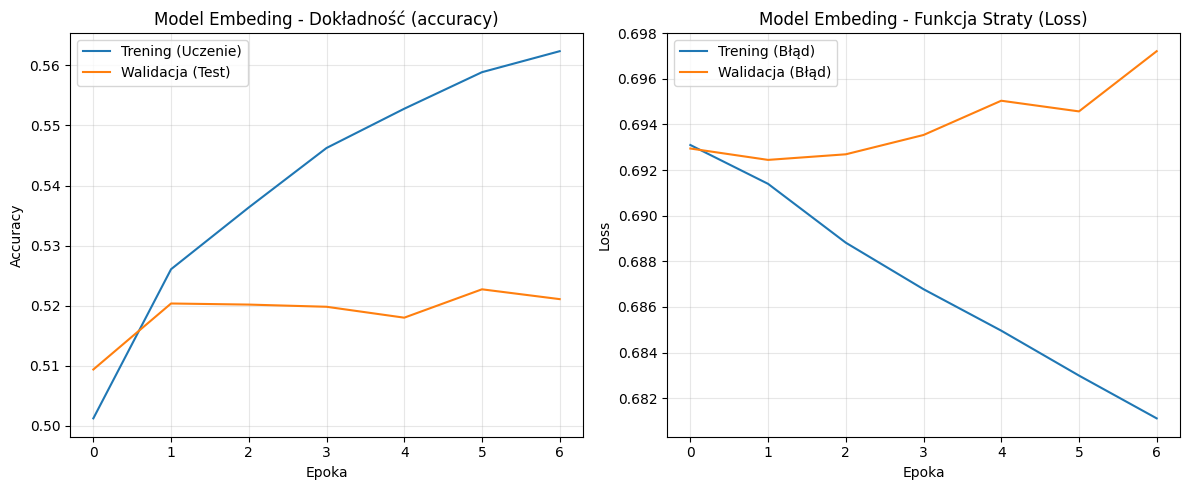

In [ ]:
plt.figure(figsize=(12, 5))

# Wykres Dokładności
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trening (Uczenie)')
plt.plot(history.history['val_accuracy'], label='Walidacja (Test)')
plt.title('Model Embeding - Dokładność (accuracy)')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Wykres Straty (Błędu)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trening (Błąd)')
plt.plot(history.history['val_loss'], label='Walidacja (Błąd)')
plt.title('Model Embeding - Funkcja Straty (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Wizualizacja przestrzeni cech ukrytych (Latent Space) bohaterów


Ładujemy najlepszy zapisany model

In [ ]:
try:
    model = load_model('najlepszy_model_lol.keras')
    print("✅ Model załadowany pomyślnie!")
except:
    print("❌ Błąd: Nie znaleziono pliku 'najlepszy_model_lol.keras'. Wgraj go do plików obok notebooka.")
    raise

✅ Model załadowany pomyślnie!


Pobieramy nazwy bohaterów z Riot DataDragon

In [ ]:
url = "https://ddragon.leagueoflegends.com/cdn/14.5.1/data/en_US/champion.json"
response = requests.get(url)
data_json = response.json()

champ_dict = {}
for champ_name, data in data_json['data'].items():
    c_id = int(data['key'])
    champ_dict[c_id] = champ_name

print(f"Pobrano {len(champ_dict)} bohaterów.")

Pobrano 167 bohaterów.


Wyciągamy warstwę Embeddingu z modelu w kodzie, ta warstwa nazywała się "Champion_Embedding"

In [ ]:
try:
    embedding_layer = model.get_layer('Champion_Embedding')
    weights = embedding_layer.get_weights()[0] # To jest macierz (Liczba_Champów x 8)
    print(f"Wyciągnięto wagi embeddingu. Kształt: {weights.shape}")
except ValueError:
    print("❌ Nie znaleziono warstwy 'Champion_Embedding'. Sprawdź nazwy warstw w model.summary()")
    raise

Wyciągnięto wagi embeddingu. Kształt: (1000, 8)


Przygotowujemy dane do wykresu

Filtrujemy tylko te ID, które faktycznie istnieją w LoL-u (wagi mogą mieć zapasowe puste indeksy)

In [ ]:
plot_data = []
labels = []

for c_id, name in champ_dict.items():
    # Sprawdzamy czy ID mieści się w zakresie modelu
    if c_id < weights.shape[0]:
        # Pobieramy wektor 8 liczb dla tego bohatera
        vector = weights[c_id]
        # Pomijamy "zerowe" wektory (jeśli model ich nie używał)
        if np.sum(np.abs(vector)) > 0:
            plot_data.append(vector)
            labels.append(name)

plot_data = np.array(plot_data)

Redukcja wymiarów (z 8D do 2D) za pomocą t-SNE

To algorytm, który idealnie układa podobne rzeczy blisko siebie

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
results_2d = tsne.fit_transform(plot_data)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Rysujemy Wykres

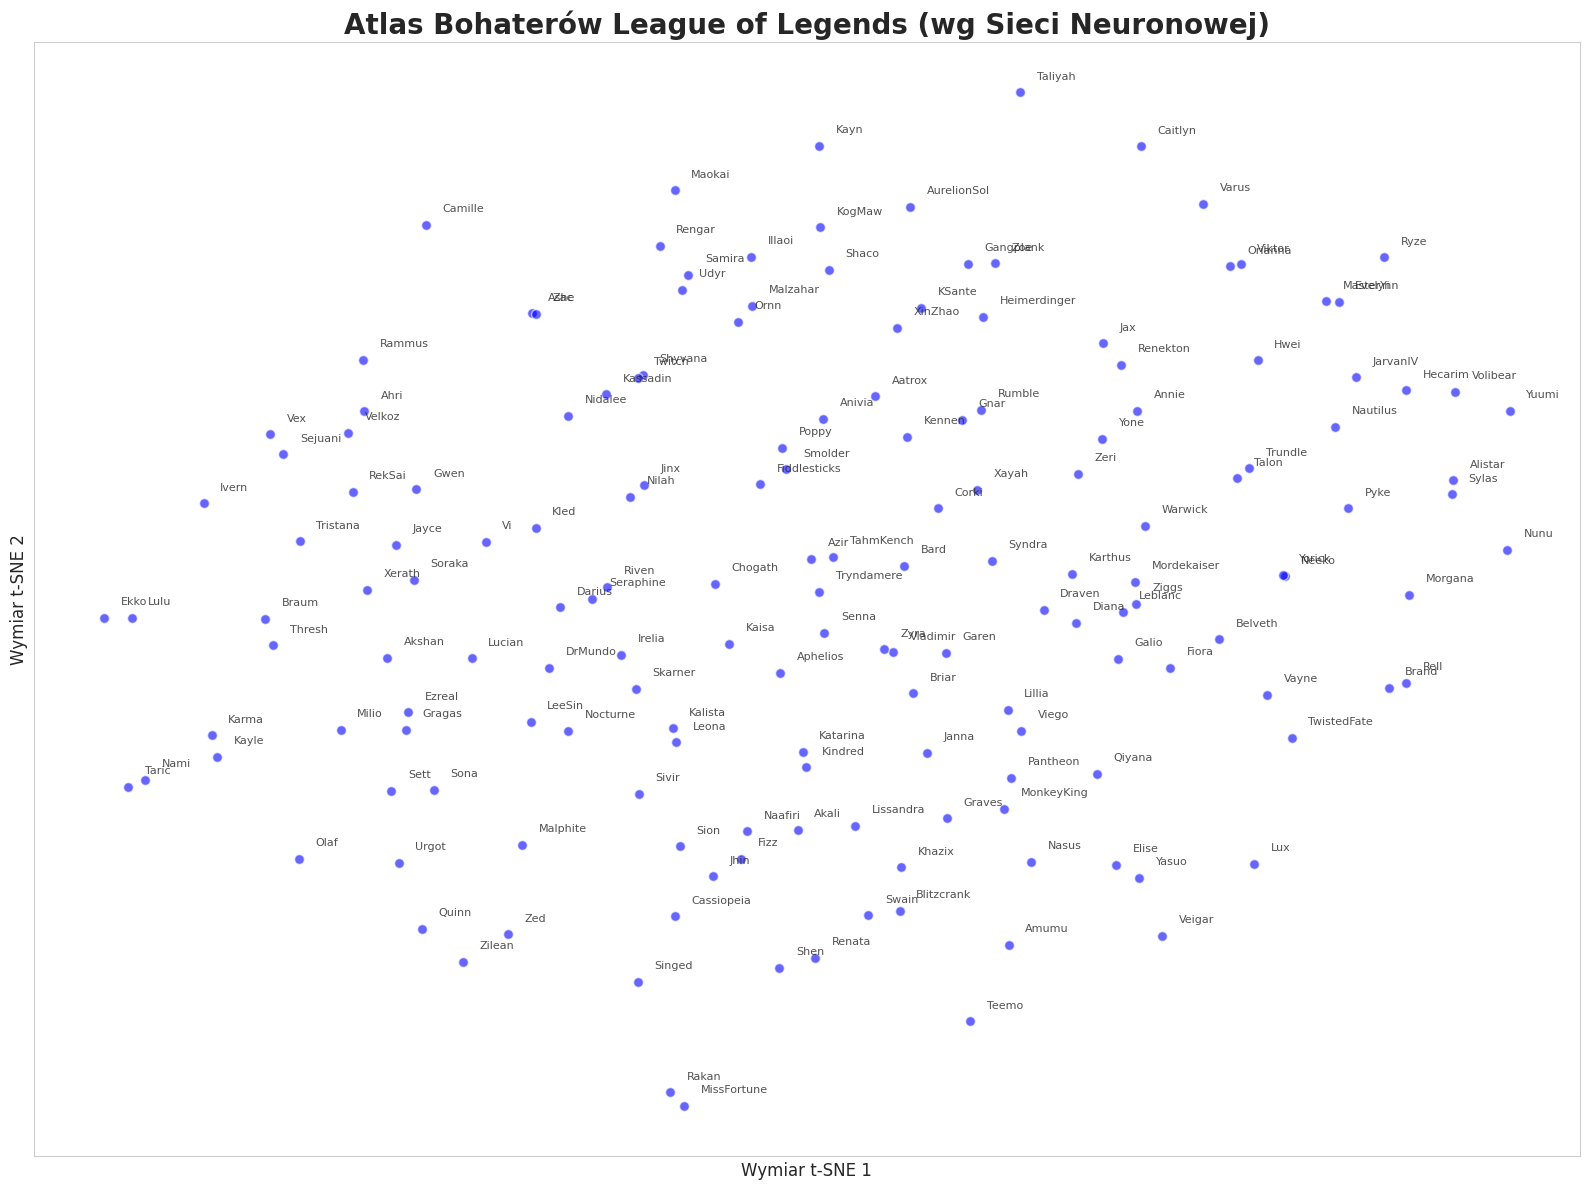

In [ ]:
plt.figure(figsize=(16, 12))
sns.set_style("whitegrid")

# Rysujemy punkty
x = results_2d[:, 0]
y = results_2d[:, 1]
plt.scatter(x, y, alpha=0.6, c='blue', edgecolors='w', s=50)

# Dodajemy podpisy
texts = []
for i, txt in enumerate(labels):
    plt.text(x[i]+0.2, y[i]+0.2, txt, fontsize=8, alpha=0.8)

plt.title('Atlas Bohaterów League of Legends (wg Sieci Neuronowej)', fontsize=20, fontweight='bold')
plt.xlabel('Wymiar t-SNE 1', fontsize=12)
plt.ylabel('Wymiar t-SNE 2', fontsize=12)

# Usunięcie osi liczbowych (bo w t-SNE liczy się tylko sąsiedztwo, a nie konkretne wartości)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

# Implementacja wyszukiwania najbliższych sąsiadów (Nearest Neighbors) w przestrzeni wektorowej (Embedding Space)

Funkcja do szukania "matematycznych sąsiadów"

In [ ]:
def find_closest_champions(target_name, top_n=5):
    # Znajdź ID dla nazwy
    target_id = None
    for c_id, name in champ_dict.items():
        if name.lower() == target_name.lower():
            target_id = c_id
            break

    if target_id is None:
        return f"Nie znaleziono bohatera: {target_name}"

    # Pobierz wektor tego bohatera
    if target_id >= len(weights):
        return "Błąd: ID bohatera poza zakresem modelu."

    target_vector = weights[target_id].reshape(1, -1)

    # Oblicz podobieństwo do wszystkich innych (Cosine Similarity)
    # Wynik 1.0 = identyczny, 0.0 = brak związku, -1.0 = przeciwieństwo
    similarities = []

    for c_id, name in champ_dict.items():
        if c_id < len(weights) and c_id != target_id:
            vec = weights[c_id].reshape(1, -1)
            if np.sum(np.abs(vec)) > 0: # pomijamy pustych
                sim = cosine_similarity(target_vector, vec)[0][0]
                similarities.append((name, sim))

    # Sortujemy od największego podobieństwa
    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities[:top_n]

Test kilku charakterystycznych postaci

In [ ]:
test_champs = ["Yasuo", "Yuumi", "Malphite", "Jinx"]

print("--- Kogo model uważa za podobnego? ---\n")

for champ in test_champs:
    print(f"Najbliżsi sąsiedzi dla: {champ}")
    neighbors = find_closest_champions(champ)
    for name, score in neighbors:
        print(f"  -> {name} (Podobieństwo: {score:.4f})")
    print("-" * 30)

--- Kogo model uważa za podobnego? ---

Najbliżsi sąsiedzi dla: Yasuo
  -> Elise (Podobieństwo: 0.8831)
  -> Veigar (Podobieństwo: 0.8007)
  -> Riven (Podobieństwo: 0.6804)
  -> Lux (Podobieństwo: 0.6636)
  -> Seraphine (Podobieństwo: 0.6516)
------------------------------
Najbliżsi sąsiedzi dla: Yuumi
  -> Volibear (Podobieństwo: 0.8151)
  -> Alistar (Podobieństwo: 0.7478)
  -> Belveth (Podobieństwo: 0.6919)
  -> Yorick (Podobieństwo: 0.6620)
  -> Neeko (Podobieństwo: 0.6585)
------------------------------
Najbliżsi sąsiedzi dla: Malphite
  -> Quinn (Podobieństwo: 0.7279)
  -> Sion (Podobieństwo: 0.6692)
  -> Ezreal (Podobieństwo: 0.6536)
  -> Ekko (Podobieństwo: 0.6324)
  -> Lucian (Podobieństwo: 0.5639)
------------------------------
Najbliżsi sąsiedzi dla: Jinx
  -> Taliyah (Podobieństwo: 0.8280)
  -> Ivern (Podobieństwo: 0.7390)
  -> Nilah (Podobieństwo: 0.6647)
  -> Ashe (Podobieństwo: 0.6157)
  -> Amumu (Podobieństwo: 0.6152)
------------------------------


# REGRESJA LOGISTYCZNA

Regresja słabo radzi sobie z surowymi ID (traktuje ID 800 jako "większe" niż ID 1)

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
print(f"Wynik Regresji Logistycznej: {acc_log*100:.2f}%")

Wynik Regresji Logistycznej: 50.73%


# Regresja z One-Hot Encoding

Sprawdzenie poprawności matematycznej modelu liniowego

In [ ]:
# 1. Przygotowanie Encodera
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

# 2. Transformacja danych
# Zamieniamy 10 kolumn z ID na ~1600 kolumn binarnych (0/1)
X_train_ohe = encoder.fit_transform(X_train)
X_test_ohe = encoder.transform(X_test)

print(f"Nowy wymiar danych wejściowych: {X_train_ohe.shape}")


log_reg_ohe = LogisticRegression(max_iter=1000, random_state=42)
log_reg_ohe.fit(X_train_ohe, y_train)

y_pred_ohe = log_reg_ohe.predict(X_test_ohe)
acc_log_ohe = accuracy_score(y_test, y_pred_ohe)
print(f"Wynik Regresji Logistycznej: {acc_log_ohe*100:.2f}%")

Nowy wymiar danych wejściowych: (44075, 1479)
Wynik Regresji Logistycznej: 51.79%


PORÓWNANIE REGRESJI

In [ ]:
try:
    print(f"1. Regresja 'Naiwna' (Surowe ID):  {acc_log*100:.2f}%")
except NameError:
    print(f"1. Regresja 'Naiwna' (Surowe ID):  (uruchom najpierw poprzedni kod)")

print(f"2. Regresja Poprawna (OHE):        {acc_log_ohe*100:.2f}%")

if acc_log_ohe > 0.5:
    print("\nWniosek: OHE pomogło modelowi zrozumieć dane!")
else:
    print("\nWniosek: Klątwa wymiarowości - za dużo kolumn, za mało danych.")

1. Regresja 'Naiwna' (Surowe ID):  50.73%
2. Regresja Poprawna (OHE):        51.79%

Wniosek: OHE pomogło modelowi zrozumieć dane!


#MODEL XGBOOST

In [ ]:
clf = xgb.XGBClassifier(
    n_estimators=300,    # Liczba drzew
    max_depth=4,         # Płytkie drzewa (żeby nie uczyły się na pamięć)
    learning_rate=0.03,  # Wolne, dokładne uczenie
    subsample=0.8,       # Używaj tylko 80% danych dla każdego drzewa
    colsample_bytree=0.8, # Używaj tylko części cech dla drzewa
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1            # Użyj wszystkich rdzeni procesora
)

# Trening
clf.fit(X_train_ohe, y_train)

# Predykcja
y_pred = clf.predict(X_test_ohe)
acc_xgb = accuracy_score(y_test, y_pred)

print(f"\n--- WYNIK XGBOOST ---")
print(f"Dokładność (Accuracy): {acc_xgb*100:.2f}%")

# Raport szczegółowy
print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred))



--- WYNIK XGBOOST ---
Dokładność (Accuracy): 50.98%

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      5531
           1       0.51      0.59      0.55      5488

    accuracy                           0.51     11019
   macro avg       0.51      0.51      0.51     11019
weighted avg       0.51      0.51      0.51     11019



## Wykres

Zamiast brać nazwy z X_train_ohe (który ich nie ma),
bierzemy je z encodera, który pamięta, co zakodował. Przypisujemy poprawne nazwy do modelu

<Figure size 1200x1000 with 0 Axes>

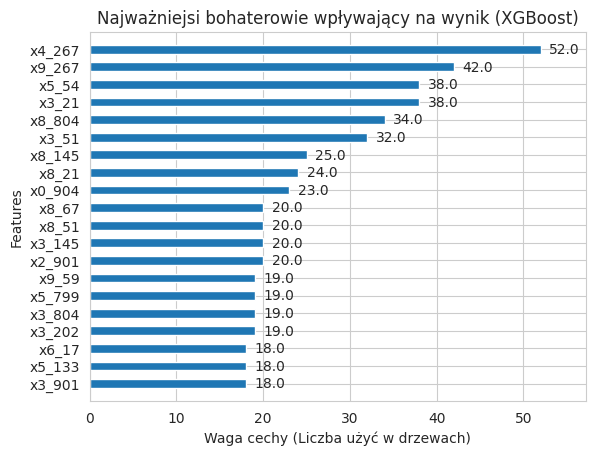

In [ ]:
feature_names = list(encoder.get_feature_names_out())

clf.get_booster().feature_names = feature_names

plt.figure(figsize=(12, 10))
xgb.plot_importance(
    clf.get_booster(),
    max_num_features=20,
    height=0.5,
    importance_type='weight',
    title='Najważniejsi bohaterowie wpływający na wynik (XGBoost)',
    xlabel='Waga cechy (Liczba użyć w drzewach)'
)
plt.show()

# LAS LOSOWY (Random Forest)

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_ohe, y_train)
y_pred_rf = rf_clf.predict(X_test_ohe)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Wynik Random Forest: {acc_rf*100:.2f}%")

Wynik Random Forest: 50.59%


# PRZYGOTOWANIE DANYCH (TARGET ENCODING)

In [ ]:
df = pd.read_csv('league_data_final.csv')

X = df_clean.drop('t1_win', axis=1)
y = df_clean['t1_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

 # Przetwarzanie danych (Zamiana ID na Winrate)

In [ ]:
# Obliczamy Winrate TYLKO na zbiorze treningowym
train_calc = X_train.copy()
train_calc['win'] = y_train

t1_cols = [c for c in X.columns if 't1_champ' in c]
t2_cols = [c for c in X.columns if 't2_champ' in c]

# Topimy dane do jednej kolumny
t1_melt = train_calc[t1_cols + ['win']].melt(id_vars='win', value_name='champ_id').drop('variable', axis=1)
t2_melt = train_calc[t2_cols + ['win']].melt(id_vars='win', value_name='champ_id').drop('variable', axis=1)
t2_melt['win'] = 1 - t2_melt['win'] # Odwracamy winrate dla T2

all_stats = pd.concat([t1_melt, t2_melt])

# Statystyki globalne
global_mean = all_stats['win'].mean()
champ_stats = all_stats.groupby('champ_id')['win'].agg(['mean', 'count'])

# Wygładzanie (Smoothing) - żeby 1 gra nie dawała 100% winrate
C = 20
champ_stats['smoothed_winrate'] = (champ_stats['count'] * champ_stats['mean'] + C * global_mean) / (champ_stats['count'] + C)
winrate_map = champ_stats['smoothed_winrate'].to_dict()

# Funkcja mapująca
def apply_winrates(data, mapping, global_avg):
    data_new = data.copy()
    for col in data.columns:
        # Podmieniamy ID na Winrate. Jak nie ma w bazie, wstawiamy średnią (0.5)
        data_new[col] = data[col].map(mapping).fillna(global_avg)
    return data_new

# TWORZYMY NOWE ZBIORY DANYCH (Same Winrate'y, zero ID)
X_train_wr = apply_winrates(X_train, winrate_map, global_mean)
X_test_wr = apply_winrates(X_test, winrate_map, global_mean)

print(f"Dane gotowe. Przykład: Zamiast ID 266 masz teraz {X_train_wr.iloc[0,0]:.4f}")
print("-" * 30)

Dane gotowe. Przykład: Zamiast ID 266 masz teraz 0.4825
------------------------------


# REGRESJA LOGISTYCZNA

In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_wr, y_train)
acc_log_TE = accuracy_score(y_test, lr.predict(X_test_wr))
print(f">> Regresja Logistyczna: {acc_log_TE*100:.2f}%")

>> Regresja Logistyczna: 52.87%


# RANDOM FOREST

In [ ]:
rf_wr = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_wr.fit(X_train_wr, y_train)
acc_rf_TE = accuracy_score(y_test, rf_wr.predict(X_test_wr))
print(f">> Random Forest (Winrate): {acc_rf_TE*100:.2f}%")

>> Random Forest (Winrate): 52.82%


# XGBOOST

In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=6, n_estimators=150)

xgb_clf.fit(X_train_wr, y_train)

acc_xgb_TE = accuracy_score(y_test, xgb_clf.predict(X_test_wr))

print(f">> XGBoost: {acc_xgb_TE*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:10:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


>> XGBoost: 52.12%


# SIEĆ NEURONOWA (DENSE)
Tutaj budujemy prostą sieć, która bierze 10 liczb (winrate'y) i mieli je warstwami Dense

In [ ]:
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_nn.fit(
    X_train_wr, y_train,
    validation_data=(X_test_wr, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0 # Ukrywamy spam epok
)

# Ocena sieci
loss, acc_NN_TE = model_nn.evaluate(X_test_wr, y_test, verbose=0)
print(f">> Sieć Neuronowa (Dense): {acc_NN_TE*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>> Sieć Neuronowa (Dense): 52.23%


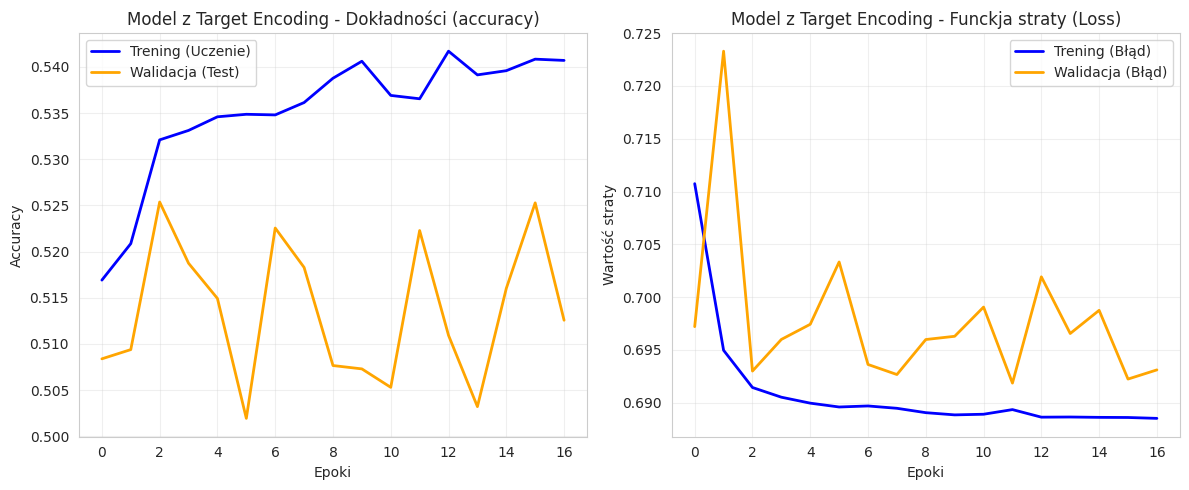

In [ ]:
h = history.history

plt.figure(figsize=(12, 5))

# --- WYKRES 1: DOKŁADNOŚĆ (ACCURACY)
plt.subplot(1, 2, 1)
plt.plot(h['accuracy'], label='Trening (Uczenie)', color='blue', linewidth=2)
plt.plot(h['val_accuracy'], label='Walidacja (Test)', color='orange', linewidth=2)
plt.title('Model z Target Encoding - Dokładności (accuracy)')
plt.xlabel('Epoki')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# --- WYKRES 2: STRATA (LOSS)
plt.subplot(1, 2, 2)
plt.plot(h['loss'], label='Trening (Błąd)', color='blue', linewidth=2)
plt.plot(h['val_loss'], label='Walidacja (Błąd)', color='orange', linewidth=2)
plt.title('Model z Target Encoding - Funckja straty (Loss)')
plt.xlabel('Epoki')
plt.ylabel('Wartość straty')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hybrydowa sieć neuronowa (Target encoding + embedding)

Pobieramy wagi embeddingów ze starego modelu


In [ ]:
pretrained_model = load_model('najlepszy_model_lol.keras')

try:
    # Wyciągamy macierz wag (np. 168 x 8)
    embedding_layer = pretrained_model.get_layer('Champion_Embedding')
    pretrained_weights = embedding_layer.get_weights()
    vocab_size = pretrained_weights[0].shape[0]
    embedding_dim = pretrained_weights[0].shape[1]
    print(f"✅ Pomyślnie wyciągnięto embeddingi! Wymiar: {vocab_size} x {embedding_dim}")
except:
    print("❌ Błąd: Nie udało się znaleźć warstwy 'Champion_Embedding'.")
    raise

✅ Pomyślnie wyciągnięto embeddingi! Wymiar: 1000 x 8


Definiujemy DWA wejścia do sieci

WEJŚCIE A: ID Championów (dla Embeddingu) - Surowe liczby całkowite Musimy wziąć oryginalne X_train, gdzie są ID postaci
Upewniamy się, że to same integery

WEJŚCIE B: Winrate'y (z Target Encoding) - Liczby zmiennoprzecinkowe

In [ ]:
input_ids = Input(shape=(10,), name="Input_IDs")
input_wr = Input(shape=(10,), name="Input_Winrates")

Gałąź Embeddingu

Tworzymy warstwę Embedding i "wstrzykujemy" jej nauczone wagi

In [ ]:
emb_layer = Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      weights=pretrained_weights, # TU JEST TRANSFER WIEDZY
                      trainable=False,            # Zamrażamy wiedzę (lub True jeśli chcemy douczać)
                      name="Transfer_Embedding")(input_ids)

# Spłaszczamy embeddingi (z 10x8 na wektor 80)
flat_emb = Flatten()(emb_layer)

Sklejamy wektor embeddingów (80 liczb) z wektorem winrate'ów (10 liczb)

In [ ]:
merged = Concatenate()([flat_emb, input_wr])

Architektura Dense

In [ ]:
x = Dense(64, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(16, activation='relu')(x)

# Wyjście
output = Dense(1, activation='sigmoid')(x)

Składamy model w całość

In [ ]:
hybrid_nn = Model(inputs=[input_ids, input_wr], outputs=output)

hybrid_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Przygotowanie danych wejściowych

Model wymaga listy dwóch macierzy: [Macierz_ID, Macierz_WR]

Upewniamy się, że X_train (ID) jest int

In [ ]:
X_train_ids = X_train.fillna(-1).astype(int)
X_test_ids = X_test.fillna(-1).astype(int)

Trening oraz ocena modelu

In [ ]:
X_train_ids = X_train.fillna(-1).astype(int)
X_test_ids = X_test.fillna(-1).astype(int)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n>> Rozpoczynam trening Hybrydowej Sieci...")
history = hybrid_nn.fit(
    x=[X_train_ids, X_train_wr],  # DWA WEJŚCIA
    y=y_train,
    validation_data=([X_test_ids, X_test_wr], y_test), # DWA WEJŚCIA TESTOWE
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Ocena
loss, acc_hybrid_nn = hybrid_nn.evaluate([X_test_ids, X_test_wr], y_test, verbose=0)
print(f"\n>> HYBRYDOWA Sieć Neuronowa: {acc_hybrid_nn*100:.2f}%")


>> Rozpoczynam trening Hybrydowej Sieci...
Epoch 1/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5045 - loss: 0.7376 - val_accuracy: 0.4996 - val_loss: 0.6943
Epoch 2/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5117 - loss: 0.6950 - val_accuracy: 0.5245 - val_loss: 0.6922
Epoch 3/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5225 - loss: 0.6922 - val_accuracy: 0.5337 - val_loss: 0.6909
Epoch 4/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5256 - loss: 0.6912 - val_accuracy: 0.5346 - val_loss: 0.6905
Epoch 5/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5334 - loss: 0.6894 - val_accuracy: 0.5283 - val_loss: 0.6906
Epoch 6/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5365 - loss: 0.6893 - val_accuracy: 0.5324 - val_loss: 0.6903
Epoch 7/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5355 - loss: 0.6892 - val_accuracy: 0.5343 - val_loss: 0.6900
Epoch 8/50
689/689 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accura

 WYKRESY dokładności i straty

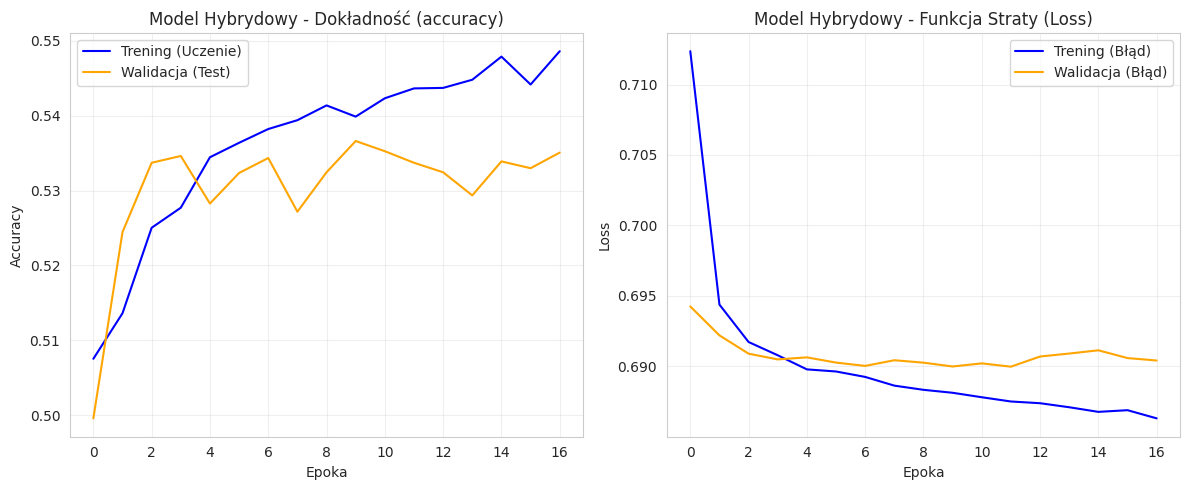

In [ ]:
plt.figure(figsize=(12, 5))

h = history.history

# --- WYKRES 1: DOKŁADNOŚĆ (ACCURACY) ---
plt.subplot(1, 2, 1)
acc = h.get('accuracy', h.get('acc', []))
val_acc = h.get('val_accuracy', h.get('val_acc', []))

plt.plot(acc, label='Trening (Uczenie)', color='blue')
plt.plot(val_acc, label='Walidacja (Test)', color='orange')
plt.title('Model Hybrydowy - Dokładność (accuracy)')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# --- WYKRES 2: STRATA (LOSS) ---
plt.subplot(1, 2, 2)
loss = h.get('loss', [])
val_loss = h.get('val_loss', [])

plt.plot(loss, label='Trening (Błąd)', color='blue')
plt.plot(val_loss, label='Walidacja (Błąd)', color='orange')
plt.title('Model Hybrydowy - Funkcja Straty (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Macierz pomyłek

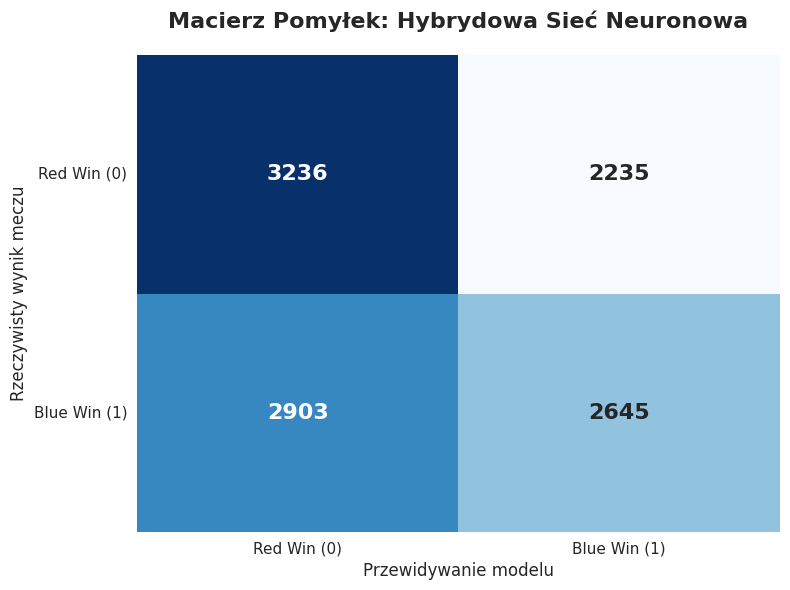


--- INTERPRETACJA WYNIKÓW ---
Poprawne trafienia (Przekątna): 5881 meczów
Błędy modelu (Poza przekątną):  5138 meczów


In [ ]:
# 1. Predykcja (Sieć zwraca prawdopodobieństwo np. 0.72)
y_pred_prob = hybrid_nn.predict([X_test_ids, X_test_wr], verbose=0)

# 2. Zamiana na decyzję (0 lub 1) - próg 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# 3. Obliczenie macierzy
cm = confusion_matrix(y_test, y_pred)

# 4. Rysowanie wykresu
plt.figure(figsize=(8, 6))

# Heatmapa (niebieska kolorystyka wygląda profesjonalnie w pracach)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={"size": 16, "weight": "bold"})

# Opisy osi i tytuł
plt.title('Macierz Pomyłek: Hybrydowa Sieć Neuronowa', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Rzeczywisty wynik meczu', fontsize=12)
plt.xlabel('Przewidywanie modelu', fontsize=12)

# Zmieniamy 0/1 na zrozumiałe napisy
plt.xticks([0.5, 1.5], ['Red Win (0)', 'Blue Win (1)'], fontsize=11)
plt.yticks([0.5, 1.5], ['Red Win (0)', 'Blue Win (1)'], fontsize=11, rotation=0)

plt.tight_layout()
plt.show()

# 5. Interpretacja tekstowa (do wklejenia w tekst pracy)
tn, fp, fn, tp = cm.ravel()
print("\n--- INTERPRETACJA WYNIKÓW ---")
print(f"Poprawne trafienia (Przekątna): {tp + tn} meczów")
print(f"Błędy modelu (Poza przekątną):  {fp + fn} meczów")


# Podstawowe metryki

In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"DOKŁADNOŚĆ (Accuracy):  {acc*100:.2f}%")
print("-" * 40)
print(f"PRECYZJA (Precision):   {prec*100:.2f}%")
print(f"CZUŁOŚĆ (Recall):       {rec*100:.2f}%")
print(f"F1-SCORE:               {f1:.4f}")

DOKŁADNOŚĆ (Accuracy):  53.37%
----------------------------------------
PRECYZJA (Precision):   54.20%
CZUŁOŚĆ (Recall):       47.67%
F1-SCORE:               0.5073


# Obliczanie Krzywej ROC i wskaźnika AUC

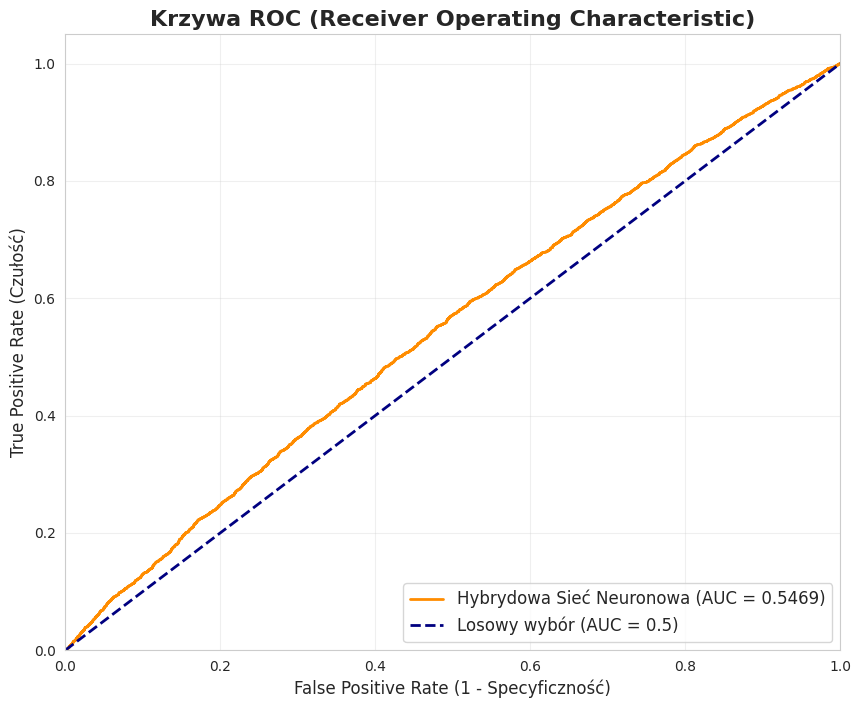

In [ ]:
# 1. Pobieramy surowe prawdopodobieństwa (float od 0.0 do 1.0)
y_pred_prob = hybrid_nn.predict([X_test_ids, X_test_wr], verbose=0).ravel()

# 2. Obliczamy punkty krzywej (FPR, TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 3. Obliczamy pole pod krzywą (AUC)
roc_auc = auc(fpr, tpr)

# 4. Rysujemy wykres
plt.figure(figsize=(10, 8))

# Krzywa modelu
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Hybrydowa Sieć Neuronowa (AUC = {roc_auc:.4f})')

# Linia losowości (przekątna)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy wybór (AUC = 0.5)')

# Upiększanie wykresu
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specyficzność)', fontsize=12)
plt.ylabel('True Positive Rate (Czułość)', fontsize=12)
plt.title('Krzywa ROC (Receiver Operating Characteristic)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# PODSUMOWANIE WYNIKÓW (TARGET ENCODING)

In [ ]:
print(f"1. Regresja: {acc_log_TE*100:.2f}%")
print(f"2. Random Forest: {acc_rf_TE*100:.2f}%")
print(f"3. XGBoost: {acc_xgb_TE*100:.2f}%")
print(f"4. Sieć Neuronowa: {acc_NN_TE*100:.2f}%")
print(f"5. Hybrydowa NN: {acc_hybrid_nn*100:.2f}%")

1. Regresja: 52.87%
2. Random Forest: 52.82%
3. XGBoost: 52.12%
4. Sieć Neuronowa: 52.23%
5. Hybrydowa NN: 53.37%


# Wyniki i Wykres
Dodajemy NOWE wyniki (Target Encoding) do listy

In [ ]:
try:
    data_list
except NameError:
    data_list = []

new_results = [
    {'Model': 'Regresja Logistyczna', 'Typ Danych': 'Target Encoding (Winrate)', 'Dokładność [%]': acc_log_TE * 100},
    {'Model': 'Random Forest',      'Typ Danych': 'Target Encoding (Winrate)', 'Dokładność [%]': acc_rf_TE * 100},
    {'Model': 'XGBoost',            'Typ Danych': 'Target Encoding (Winrate)', 'Dokładność [%]': acc_xgb_TE * 100},
    {'Model': 'Sieć Neuronowa',     'Typ Danych': 'Target Encoding (Winrate)', 'Dokładność [%]': acc_NN_TE * 100},
    {'Model': 'Hybrydowa NN',       'Typ Danych': 'Hybrid (TE + Embedding)',   'Dokładność [%]': acc_hybrid_nn * 100}
]

data_list.extend(new_results)

# Wykres i tabela wyników

KONFIGURACJA DANYCH - czyli słownik wszystkich modeli


In [ ]:
all_models_config = {
    # GRUPA 1: PIERWSZE PODEJŚCIE (Surowe / OHE / Embedding)
    'acc_log':     ('Regresja Logistyczna', 'Surowe ID'),
    'acc_log_ohe': ('Regresja Logistyczna', 'One-Hot Encoding'),
    'acc_rf':      ('Random Forest',       'One-Hot Encoding'),
    'acc_xgb':     ('XGBoost',             'One-Hot Encoding'),
    'acc_NN':      ('Sieć Neuronowa',      'Embedding (Samo ID)'),

    # GRUPA 2: DRUGIE PODEJŚCIE (Target Encoding)
    'acc_log_TE':  ('Regresja Logistyczna', 'Target Encoding'),
    'acc_rf_TE':   ('Random Forest',       'Target Encoding'),
    'acc_xgb_TE':  ('XGBoost',             'Target Encoding'),
    'acc_NN_TE':   ('Sieć Neuronowa',      'Target Encoding'),

    # GRUPA 3: NAJNOWSZE PODEJŚCIE (Hybryda)
    'acc_hybrid_nn': ('Sieć Neuronowa',    'Hybrid (TE + Emb)')
}

Zbieranie wyników z pamięci

In [ ]:
data_list = []

for var_name, (model_name, method_name) in all_models_config.items():
    # Sprawdzamy, czy taka zmienna istnieje w Notebooku
    val = globals().get(var_name)

    if val is not None:
        score = val * 100 if val <= 1.0 else val
        data_list.append({
            'Model': model_name,
            'Metoda': method_name,
            'Dokładność [%]': score
        })

Rysowanie wykresu

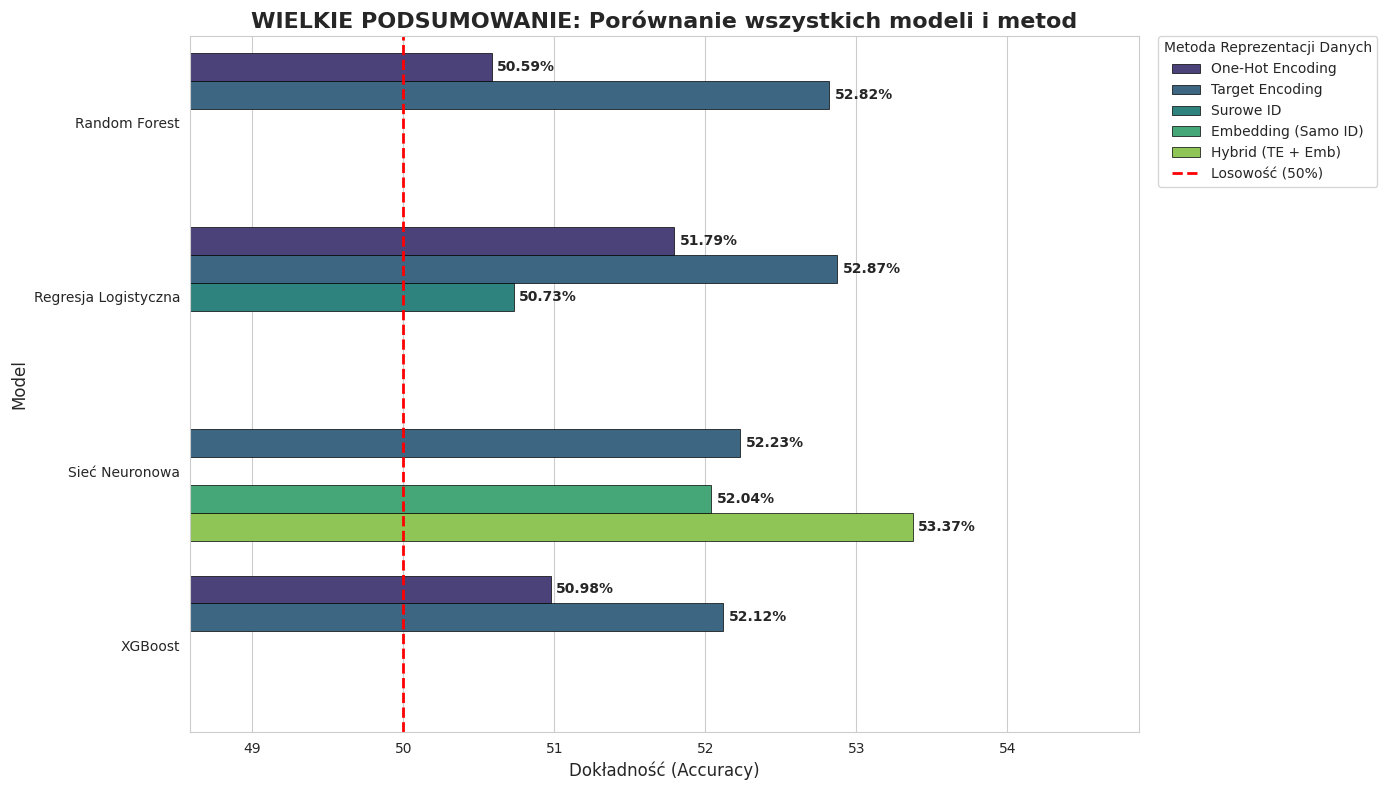

In [ ]:
if not data_list:
    print("BŁĄD: Nie znaleziono żadnych wyników w pamięci! Uruchom komórki z treningiem.")
else:
    df_results = pd.DataFrame(data_list)

    # Sortujemy: Najpierw Model, potem Wynik (żeby słupki były ładnie pogrupowane)
    df_results = df_results.sort_values(by=['Model', 'Dokładność [%]'], ascending=[True, True])

    plt.figure(figsize=(14, 8))
    sns.set_style("whitegrid")

    # Główny Wykres
    ax = sns.barplot(
        data=df_results,
        y='Model',              # Modele na osi Y
        x='Dokładność [%]',     # Wyniki na osi X
        hue='Metoda',           # Kolory oznaczają metodę (OHE, TE, Hybrid...)
        palette='viridis',
        edgecolor='black',
        linewidth=0.5
    )

    # Dodawanie etykiet z wartościami na słupkach
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', padding=4, fontsize=10, weight='bold')

    # Tytuły i opisy
    plt.title('WIELKIE PODSUMOWANIE: Porównanie wszystkich modeli i metod', fontsize=16, weight='bold')
    plt.xlabel('Dokładność (Accuracy)', fontsize=12)
    plt.ylabel('Model', fontsize=12)

    # Inteligentne skalowanie osi X (Zoom na wyniki)
    # Zaczynamy wykres trochę poniżej najsłabszego wyniku, żeby było widać różnice
    min_val = df_results['Dokładność [%]'].min()
    max_val = df_results['Dokładność [%]'].max()
    plt.xlim(max(45, min_val - 2), max_val + 1.5)

    # Linia odniesienia (Rzut monetą)
    plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Losowość (50%)')

    # Legenda poza wykresem, żeby nie zasłaniała słupków
    plt.legend(title='Metoda Reprezentacji Danych', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.tight_layout()
    plt.show()

# Tabela z wynikami

In [ ]:
 display(df_results[['Model', 'Metoda', 'Dokładność [%]']].sort_values(by='Dokładność [%]', ascending=False).reset_index(drop=True))

,Model,Metoda,Dokładność [%]
0,Sieć Neuronowa,Hybrid (TE + Emb),53.371447
1,Regresja Logistyczna,Target Encoding,52.872311
2,Random Forest,Target Encoding,52.817860
3,Sieć Neuronowa,Target Encoding,52.227968
4,XGBoost,Target Encoding,52.119067
5,Sieć Neuronowa,Embedding (Samo ID),52.037388
6,Regresja Logistyczna,One-Hot Encoding,51.792359
7,XGBoost,One-Hot Encoding,50.975588
8,Regresja Logistyczna,Surowe ID,50.730556
9,Random Forest,One-Hot Encoding,50.585353


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
import pandas as pd

# 1. Przygotowanie wejść dla Sieci Hybrydowej (Dokładnie 2 wejścia: ID i Winrate)
# Zgodnie z Twoim notatnikiem (Cell 93-95), model oczekuje listy: [Macierz_ID, Macierz_WR]
hybrid_input = [X_test_ids, X_test_wr]

# 2. Generowanie predykcji dla Sieci Hybrydowej
print("Generowanie predykcji dla Sieci Hybrydowej...")
y_pred_prob_hybrid = hybrid_nn.predict(hybrid_input)
y_pred_hybrid = (y_pred_prob_hybrid > 0.5).astype(int).flatten()

# 3. Generowanie predykcji dla modelu bazowego (Logistic Regression OHE)
# Używamy modelu log_reg_ohe z Twojej komórki 54
print("Generowanie predykcji dla modelu bazowego (Logistic Regression OHE)...")
y_pred_ohe = log_reg_ohe.predict(X_test_ohe)

# 4. Funkcja testu McNemara
def perform_mcnemar(y_true, pred_a, pred_b):
    # Sprawdzamy poprawność trafień dla każdego meczu
    a_correct = (pred_a == y_true)
    b_correct = (pred_b == y_true)

    # Tworzymy tabelę 2x2 (contingency table)
    table = pd.crosstab(a_correct, b_correct)

    # Wykonujemy test McNemara (exact=True dla małych próbek,
    # ale przy Twoich 12k meczach wynik będzie bardzo stabilny)
    result = mcnemar(table.values, exact=True)
    return result.pvalue

# 5. Wynik końcowy
p_val = perform_mcnemar(y_test, y_pred_hybrid, y_pred_ohe)

print("\n" + "="*45)
print("  WYNIK TESTU STATYSTYCZNEGO DLA PRACY")
print("="*45)
print(f"Porównanie: Sieć Hybrydowa vs Logistic Regression OHE")
print(f"P-value: {p_val:.20f}")
print("-"*45)

if p_val < 0.05:
    print("WYNIK ISTOTNY STATYSTYCZNIE!")
    print("Potwierdzono przewagę Twojej Sieci Hybrydowej.")
else:
    print("Brak istotności statystycznej (p >= 0.05).")

Generowanie predykcji dla Sieci Hybrydowej...
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Generowanie predykcji dla modelu bazowego (Logistic Regression OHE)...

  WYNIK TESTU STATYSTYCZNEGO DLA PRACY
Porównanie: Sieć Hybrydowa vs Logistic Regression OHE
P-value: 0.00000004340875548130
---------------------------------------------
WYNIK ISTOTNY STATYSTYCZNIE!
Potwierdzono przewagę Twojej Sieci Hybrydowej.


In [ ]:
# Wyświetlenie dokładnej tabeli z liczbami do pracy
table = pd.crosstab(y_pred_hybrid == y_test, y_pred_ohe == y_test)
print("--- DANE DO TABELI LATEX ---")
print(table)

--- DANE DO TABELI LATEX ---
t1_win  False  True 
t1_win              
False    2604   2534
True     2940   2941


# Wnioski
Wszystkie modele po zastosowaniu Target Encoding polepszyły swoje wyniki, przekroczyły próg losowości (50%), a najlepszy z nich uzyskał przewagę 3 p.p. nad rzutem monetą. Choć jest to wynik istotny statystycznie, stabilizacja skuteczności wokół poziomu 53% wskazuje na istnienie "szklanego sufitu" (Draft Ceiling). Dowodzi to, że nawet przy dostarczeniu modelom precyzyjnej wiedzy o sile postaci (Meta), sam dobór bohaterów determinuje wynik meczu na poziomie Diament+ jedynie w niewielkim stopniu.